Data Science Stack Exchange is a question-answer forum, to connect the Data Science community. Questions regarding Data Science - Machine Learning, Statistical Mathematics, Visualizations etc. Each post usually contains a question asked pertaining to above topics and attached are a string of answers.
These questions are useful for our goal to determine content that is most popular and best to write about. <br>

Looking at the Stack Exchange Database - <a href=https://data.stackexchange.com/datascience/query/new>Link</a><br>

The most relevant Table is the Posts table, The following attributes(columns) seem the most relevant:<br>

    PostTypeId 
    CreationDate
    Score
    ViewCount
    Tags
    AnswerCount
    FavoriteCount
<br>
Out of the type of posts, we will mainly focus on the Questions and Answers. The other kind of posts are inconsequential.<br>

The database is queried for all questions & answers in 2019 with above columns, and stored in the csv file - 2019_questions.csv


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

In [17]:
df = pd.read_csv('2019_questions.csv',parse_dates=['CreationDate'])

In [18]:
df.isna().sum()

Id                  0
CreationDate        0
Score               0
ViewCount           0
Tags                0
AnswerCount         0
FavoriteCount    7432
dtype: int64

Only the favorite column has missing values. 

In [35]:
df.Tags

0            [python, keras, tensorflow, cnn, probability]
1                                         [neural-network]
2                            [python, ibm-watson, chatbot]
3                                                  [keras]
4        [r, predictive-modeling, machine-learning-mode...
                               ...                        
21571                                   [statistics, data]
21572       [machine-learning, neural-network, classifier]
21573                   [machine-learning, classification]
21574                                 [tensorflow, python]
21575                  [python, deep-learning, tensorflow]
Name: Tags, Length: 21576, dtype: object

Looking at the Tags column, it requires cleaning. The rest of the columns are clean.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null datetime64[ns]
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    1407 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 483.5+ KB


In [19]:
df.fillna(0,inplace=True)
df.FavoriteCount = df.FavoriteCount.astype(int)

In [20]:
df.Tags = df.Tags.str.replace("><",",")
df.Tags = df.Tags.str.replace("[<>]","")
df.Tags = df.Tags.str.split(",")

Tags is the most important column, as it can give us an idea what topics are most popular. Creating a new dataframe by separating the tags and taking the number of posts with those tags and views on it into account.

In [10]:
tags = np.unique(np.concatenate(df.Tags,axis=None))
tag_count = {}

def count_tags(tag,data):
    ctr=0
    for row in data['Tags']:
        if tag in row:
            ctr+=1
    return ctr

def count_views(tag,data):
    ctr=0
    for row in data[['Tags','ViewCount']].iterrows():
        if tag in row[1]['Tags']:
            ctr+=row[1]['ViewCount']
    return ctr

for tag in tags:
    tag_count[tag] = [count_tags(tag,df),count_views(tag,df)]

df_tags = pd.DataFrame.from_dict(tag_count,orient='index').reset_index()
df_tags.columns = ['Tags','TagCount','ViewCount']

From this new dataframe, visualizing the top Tags based on View Count and Tag Count

/dataquest/system/env/python3/lib/python3.4/site-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



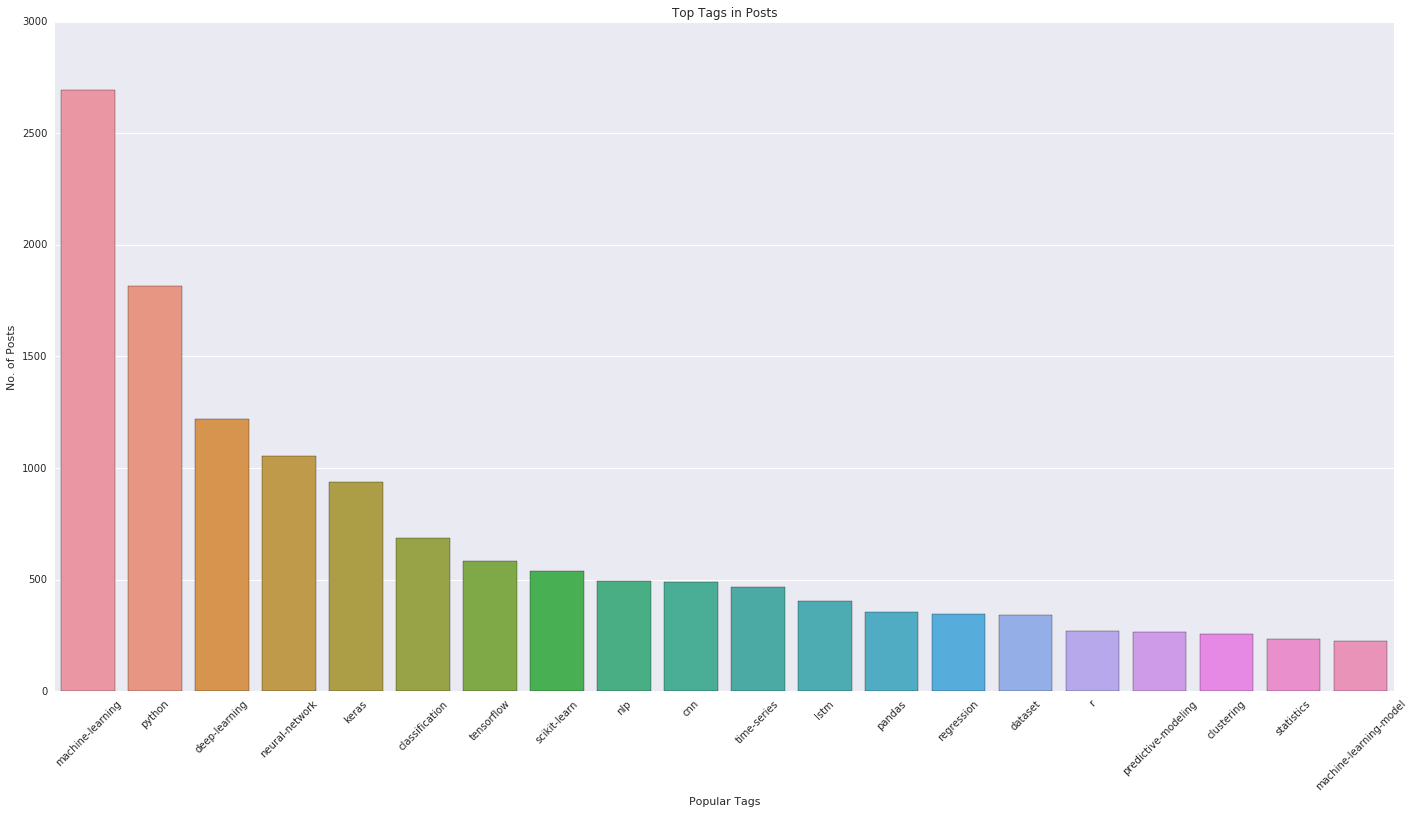

In [85]:
df_tags.sort_values(by='TagCount',ascending=False,inplace=True)
most_used = df_tags.Tags.iloc[:20]

plt.figure(figsize=(24,12))
sns.barplot(x=df_tags.Tags.iloc[0:20],y=df_tags.TagCount.iloc[0:20])
plt.xlabel("Popular Tags")
plt.ylabel("No. of Posts")
plt.xticks(rotation=45)
plt.title("Top Tags in Posts")
plt.show()

/dataquest/system/env/python3/lib/python3.4/site-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



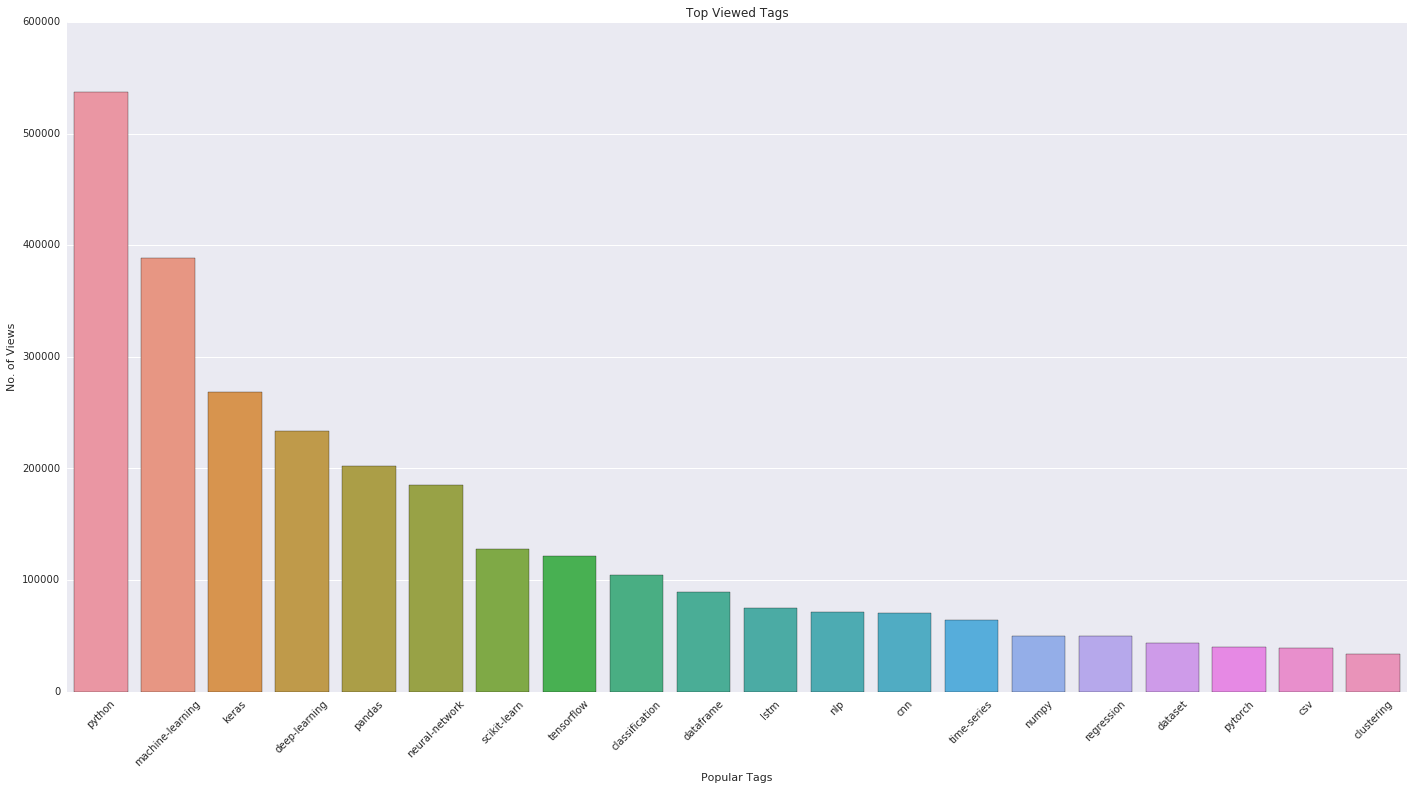

In [86]:
df_tags.sort_values(by='ViewCount',ascending=False,inplace=True)
most_viewed = df_tags.Tags.iloc[:20]

plt.figure(figsize=(24,12))
sns.barplot(x=df_tags.Tags.iloc[0:20],y=df_tags.ViewCount.iloc[0:20])
plt.xlabel("Popular Tags")
plt.ylabel("No. of Views")
plt.xticks(rotation=45)
plt.title("Top Viewed Tags")
plt.show()

Looking at the graph above, we can conclude that many tags are common between the two graphs.

In [97]:
popular_tags = np.intersect1d(most_used,most_viewed)
popular_tags

array(['classification', 'clustering', 'cnn', 'dataset', 'deep-learning',
       'keras', 'lstm', 'machine-learning', 'neural-network', 'nlp',
       'pandas', 'python', 'regression', 'scikit-learn', 'tensorflow',
       'time-series'], dtype=object)

Between the two segments there are 16 common tags. These tags are the most popular tags<br>
We can observe the tags mostly belong to a common topic, Based on the dataset, we can find relations between these tags to better understand which pairs or sets of tags are widely popular.<br>

One method is to make all possible pairs from the popular tags and make a table with the pair's Tag count and View count. This can give us popularity of a pair of Tags.<br>
We will use Pairs from the popular tags and not the entire tags list, because since we made the assumption that the top 20 are most frequent and rest are not, we can eliminate the rest of the pairs by Upward Closure property of Data Mining

In [105]:
pair_tags = list(combinations(popular_tags,2))
pair_tag_count = {}

def count_pair(tags,data):
    ctr=0
    for row in data['Tags']:
        if set(tags).issubset(row):
            ctr+=1
    return ctr

def count_pair_views(tags,data):
    ctr=0
    for row in data[['Tags','ViewCount']].iterrows():
        if set(tags).issubset(row[1]['Tags']):
            ctr+=row[1]['ViewCount']
    return ctr

for tags in pair_tags:
    pair_tag_count[tags] = [count_pair(tags,df),count_pair_views(tags,df)]
    
df_pair_tags = pd.DataFrame.from_dict(pair_tag_count,orient='index').reset_index()
df_pair_tags.columns = ['Tags','TagCount','ViewCount']

In [111]:
df_pair_tags.sort_values(by='TagCount',ascending=False,inplace=True)
most_used_pair = df_pair_tags.Tags.iloc[:20]

df_pair_tags.sort_values(by='ViewCount',ascending=False,inplace=True)
most_viewed_pair = df_pair_tags.Tags.iloc[:20]

We applied the same logic to pairs as we did to single tags. By this we go the most popular tags used together. Since to start with we used popular tags to form pairs, the resulting set of pairs we achieved tells us out of the popular tags, which pairs are related or often referred together.

In [119]:
popular_tags_pair = np.intersect1d(most_used_pair,most_viewed_pair)
popular_tags_pair

array([('classification', 'machine-learning'), ('deep-learning', 'keras'),
       ('deep-learning', 'machine-learning'),
       ('deep-learning', 'neural-network'), ('deep-learning', 'python'),
       ('deep-learning', 'tensorflow'), ('keras', 'lstm'),
       ('keras', 'machine-learning'), ('keras', 'neural-network'),
       ('keras', 'python'), ('keras', 'tensorflow'),
       ('machine-learning', 'neural-network'),
       ('machine-learning', 'python'),
       ('machine-learning', 'scikit-learn'), ('pandas', 'python'),
       ('python', 'scikit-learn'), ('python', 'tensorflow')], dtype=object)

An even simpler way of doing this is to apply Apriori Algorithm to get the frequent item sets with TagCount and ViewCount respectively

For the first analysis of our problem, we have found the most popular tags and the most popular pair of tags on Data Science Stack Exchange posts (Questions)<br>
For the next part of our analysis we are going to understand the popularity of deep learning and its increase across time. For this we pulled all the questions from Stack Exchange server in the file - all_questions.csv

In [2]:
df = pd.read_csv('all_questions.csv',parse_dates=True)

In [3]:
df.Tags = df.Tags.str.replace("><",",")
df.Tags = df.Tags.str.replace("[<>]","")
df.Tags = df.Tags.str.split(",")

In [4]:
df.CreationDate = pd.to_datetime(df.CreationDate)
df['Year'] = df.CreationDate.dt.year

Assuming those posts that have deep-learning tags are relevant to this analysis, this a new column is created.<br>
For each year the sum of posts with deep-learning tags and total posts is taken into a dataframe for further analysis

In [5]:
df['is_relevant'] = df.Tags.apply(
    lambda x: 1 if 'deep-learning' in x else 0
)

In [6]:
grouped_1 = df.groupby(by=['Year'])
grouped_2 = df[df.is_relevant == 1].groupby(by=['Year'])

In [7]:
temp_1 = pd.DataFrame(grouped_2.size(),columns=['DL_posts']).reset_index()
temp_2 = pd.DataFrame(grouped_1.size(),columns=['Total']).reset_index()

In [8]:
df_posts = pd.merge(temp_1,temp_2,left_on=['Year'],right_on=['Year'],how='inner')

In [9]:
df_posts['Percentage'] = (df_posts.DL_posts/df_posts.Total) * 100
df_posts.set_index('Year',inplace=True)
df_posts

,DL_posts,Total,Percentage
Year,,,
2014,8,562,1.423488
2015,30,1167,2.570694
2016,157,2146,7.315937
2017,425,2957,14.372675
2018,902,5475,16.474886
2019,1216,8810,13.802497
2020,67,459,14.596950


Making a plot to understand the trend in the popularity of deep-learning questions, excluding 2020 as it is the current year.

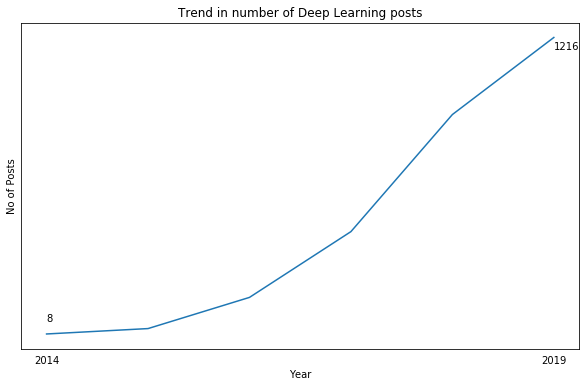

In [34]:
plt.figure(figsize=(10,6))
sns.lineplot(x=df_posts.index[:-1],y=df_posts.iloc[:-1].DL_posts)
plt.xlabel("Year")
plt.ylabel("No of Posts")
plt.title("Trend in number of Deep Learning posts")
plt.tick_params(left=False,bottom=False)
plt.yticks([])
plt.xticks([2014,2019])
plt.text(max(df_posts.index[:-1]),max(df_posts.DL_posts)-50,max(df_posts.DL_posts))
plt.text(min(df_posts.index[:-1]),min(df_posts.DL_posts)+50,min(df_posts.DL_posts))
plt.show()

We can see that year by year the trend in the no. of posts on deep learning is increasing. Thus it seems to be a very relevant topic for the analysis.